## Check one reservoir at a time
You can enter the name of a file and run the script for just that one reservoir to check what it looks like. It generates images of each depth slice. I'm making this notebook because some of the reservoirs in query_with_bounding_boxes.ipynb didn't look quite right, like as the depth went up the surface area would sometimes be smaller. So I'm making this notebook just to see what's happening. Just define the location of the csv file of gauge data you are interested in and press shift + enter

In [1]:
#imports
import os
import xarray as xr
import numpy as np
import pandas as pd
import csv
#import glob    #This one lets you read all the csv files in a directory
import rasterio.crs
from tqdm.auto import tqdm #this one is a loading bar, it's cool to add loading bars to loops
from pandas import DataFrame
import geopandas as gpd
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
from matplotlib import pyplot
import datacube

import sys
sys.path.append('../../Scripts')
from dea_spatialtools import xr_rasterize
from dea_datahandling import wofs_fuser
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.utils import masking
from datacube.helpers import ga_pq_fuser, write_geotiff
#from digitalearthau.utils import wofs_fuser
#import DEAPlotting, DEADataHandling
import warnings
warnings.filterwarnings('ignore', module='datacube')
%load_ext autoreload
%autoreload 2

/env/lib/python3.6/site-packages/cligj/__init__.py:17: FutureWarning: cligj 1.0.0 will require Python >= 3.7
  warn("cligj 1.0.0 will require Python >= 3.7", FutureWarning)


In [4]:
csv = '00_Library/Bedford_Weir_130104A.csv'


#Get the ID of the gauge 
gauge_number_df = pd.read_csv(csv, nrows=1, escapechar='#')
column2 = list(gauge_number_df)[1]
gauge_number_df = gauge_number_df.rename(columns = {column2 : 'gauge_ID'})
ID_str = gauge_number_df.at[0, 'gauge_ID']
#ID_str = ID_str.astype(str)  #If this box returns an error it might be because the ID for that gauge is already a string. 
                             #If you get an error about strings you can hash this line out.
#Make depth duration curve
gauge_data = pd.read_csv(csv,
                error_bad_lines = False, skiprows=9, escapechar='#',
                         parse_dates=['Timestamp'], 
                         index_col=('Timestamp'),
                        date_parser=lambda x: pd.to_datetime(x.rsplit('+', 1)[0])) #Robbi wrote this line
gauge_data = gauge_data.dropna()
gauge_data = gauge_data.sort_values('Value')
gauge_data['rownumber'] = np.arange(len(gauge_data))
gauge_data['Exceedence'] = (1-(gauge_data.rownumber/len(gauge_data)))*100
gauge_data = gauge_data.drop(columns=['Interpolation Type', 'Quality Code'])

#Get the depth range and intervals
depth_integers = gauge_data.astype(np.int64)
max_depth = depth_integers.Value.max()
min_depth = depth_integers.Value.min()
integer_array = depth_integers.Value.unique()
integer_list = integer_array.tolist()

#Take every 2m of depth if the reservoir is large 
if len(integer_list) > 25:
    integer_list2 = integer_list[::1]
    print('This reservoir will take every 1m instead of every 1m, because it is quite large.')
else:
        integer_list2 = integer_list
        print('This reservoir will take every 1m of depth')
        
print('Number of depth intervals = ', len(integer_list2)) 

#Get the bounding box for the satellite query
bb_gdf = gpd.read_file('00_Lib_bound/00_Lib_bound.shp')
bb_gdf = bb_gdf.set_index(['gauge_ID'])
row_n = bb_gdf.index.get_loc(ID_str)
box_row = bb_gdf.loc[ID_str]
box = box_row.geometry#[0]  #If you are getting an error in the next box it might be because you are calling 2 bounding boxes
                            #use [0] to just get one bounding box if you are getting an error about polygons

print('Gauge ID = ', ID_str)
print('Depth intervals = ', len(integer_list2))
print('Polygon extent = ', box)

This reservoir will take every 1m of depth
Number of depth intervals =  15
Gauge ID =  130104A
Depth intervals =  15
Polygon extent =  POLYGON ((148.7830201496235 -23.34641351043465, 148.842043166839 -23.37097393985625, 148.8342401292131 -23.38972600710317, 148.7752171119976 -23.36516557768158, 148.7830201496235 -23.34641351043465))


Number of images for  118  =  3
This is the area as calculated from wet pixels at 118 :  544375
Number of images for  119  =  18
This is the area as calculated from wet pixels at 119 :  747500
Number of images for  120  =  44
This is the area as calculated from wet pixels at 120 :  738125
Number of images for  121  =  73
This is the area as calculated from wet pixels at 121 :  935625
Number of images for  122  =  568
This is the area as calculated from wet pixels at 122 :  1384375
Number of images for  123  =  265
This is the area as calculated from wet pixels at 123 :  1594375
Number of images for  124  =  167
This is the area as calculated from wet pixels at 124 :  1706875
Number of images for  125  =  0
This is the area as calculated from wet pixels at 125 :  0
Number of images for  126  =  1
This is the area as calculated from wet pixels at 126 :  1225625
Number of images for  127  =  0
This is the area as calculated from wet pixels at 127 :  0
Number of images for  128  =  0
This 

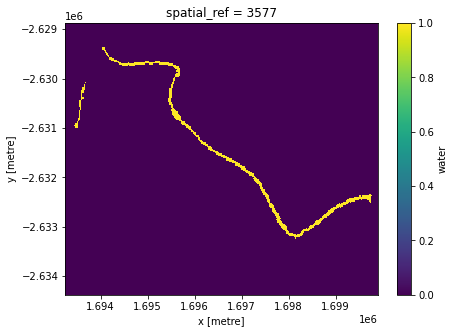

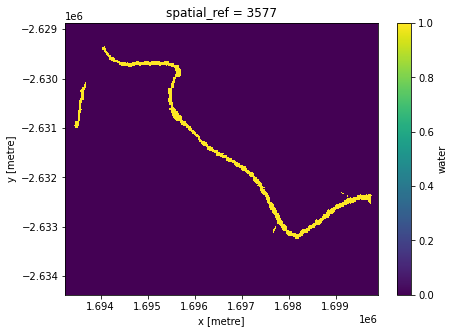

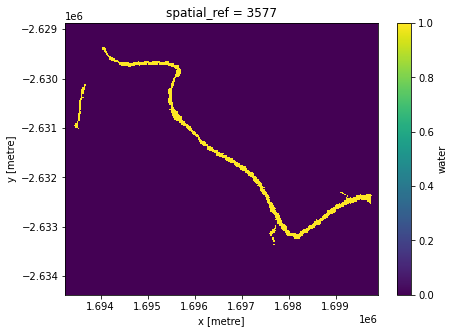

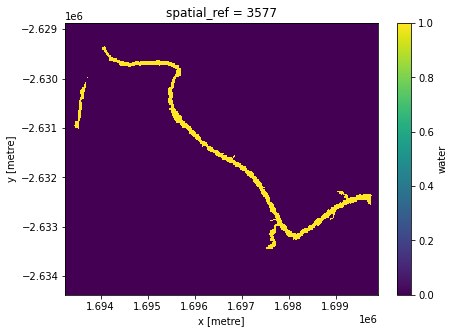

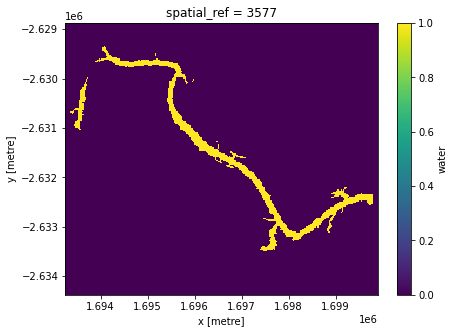

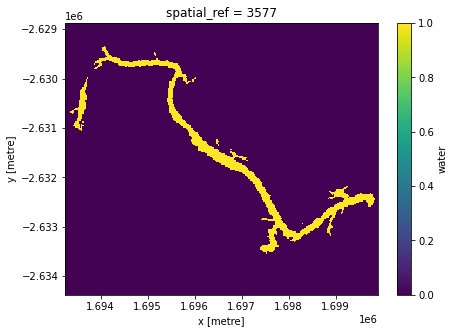

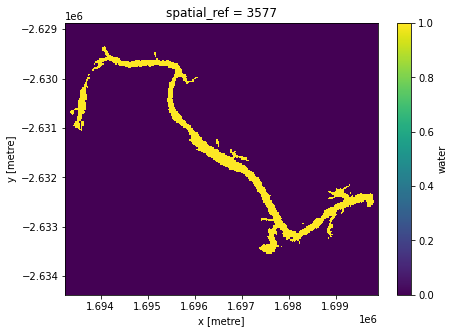

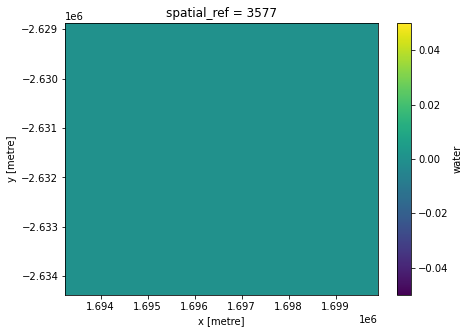

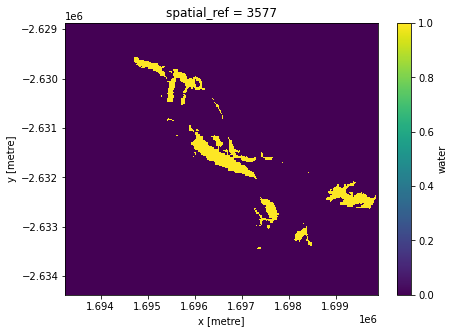

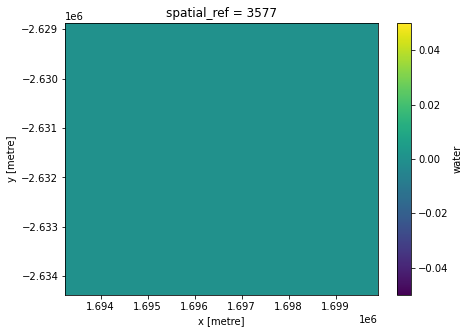

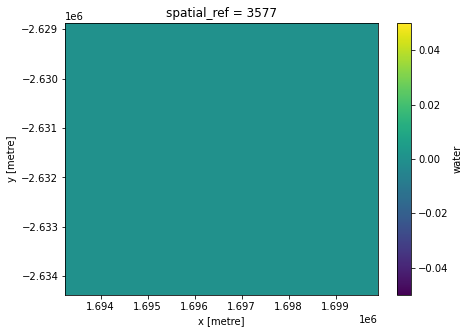

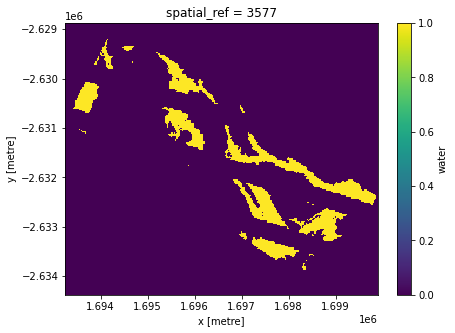

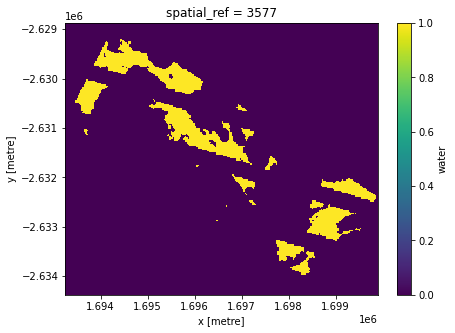

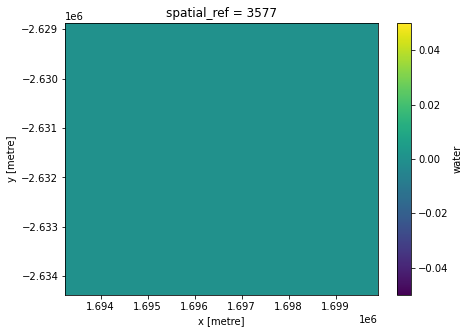

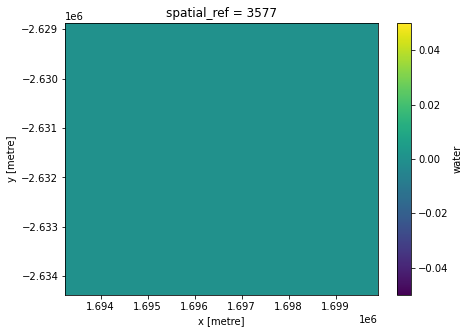

In [5]:
geom = geometry.Geometry(geom=box, crs=bb_gdf.crs)
query = {'time': ('01-01-1988', '09-12-2020')}
query.update({'geopolygon': geom})

dc = datacube.Datacube(app='dc-WOfS')

wofs_albers= dc.load(product = 'wofs_albers', dask_chunks = {}, group_by='solar_day', fuse_func = wofs_fuser, **query)
poly_mask = xr_rasterize(bb_gdf.geometry, wofs_albers)
wofs_albers = wofs_albers.where(poly_mask, other=wofs_albers.water.nodata) #put other or all the data turns into 0

gauge_data_xr = gauge_data.to_xarray() #convert gauge data to xarray
merged_data = gauge_data_xr.interp(Timestamp=wofs_albers.time) #use xarrays .interp() function to merge

surface_area_list = []
number_of_images_list = []

for i in integer_list2:
    #If there are more than 25 meters in depth intervals, take every 2m depth
    if len(integer_list) > 25:
        specified_level = merged_data.where((merged_data.Value > i) & 
                                    (merged_data.Value < i+1), drop=True)
    else:
        specified_level = merged_data.where((merged_data.Value > i) & 
                                    (merged_data.Value < i+1), drop=True)
    
    date_list = specified_level.time.values #[:50] #cap at 50 images (makes it run faster)
    number_of_images = len(date_list)
    number_of_images_list.append(number_of_images)
    print('Number of images for ', i, ' = ', len(date_list))
    specified_passes = wofs_albers.sel(time=date_list).compute() #This .compute() Xarray function loads actual images
    
    #cloudmask (Claire Krause wrote this for me)
    cc = masking.make_mask(specified_passes.water, cloud=True)
    ncloud_pixels = cc.sum(dim=['x', 'y'])
    # Calculate the total number of pixels per timestep
    npixels_per_slice = (specified_passes.water.shape[1] * 
                         specified_passes.water.shape[2])
    cloud_pixels_fraction = (ncloud_pixels / npixels_per_slice)
    clear_specified_passes = specified_passes.water.isel(
        time=cloud_pixels_fraction < 0.2)
    wet = masking.make_mask(clear_specified_passes, wet=True).sum(dim='time')
    dry = masking.make_mask(clear_specified_passes, dry=True).sum(dim='time')
    clear = wet + dry
    frequency = wet / clear
    frequency = frequency.fillna(0)  
   
    #Get area from the satellite data
    #get the frequency array
    frequency_array = frequency.values
    #Turn any pixel in the frequency array with a value greater than 0.2 into a pixel of value 1
    #if the pixel value is 0.2 or lower it gets value 0
    is_water = np.where((frequency_array > 0.2),1,0)
    #give the 'frequency' xarray back its new values of zero and one
    frequency.values = is_water
    #sum up the pixels
    number_water_pixels = frequency.sum(dim=['x', 'y'])
    #get the number
    number_water_pixels = number_water_pixels.values.tolist()
    #multiply by pixel size to get area in m2
    area_m2 = number_water_pixels*(25*25)
    
    surface_area_list.append(area_m2)
    print('This is the area as calculated from wet pixels at', i, ': ', area_m2)

    #Plotting the image
    frequency.plot(figsize = (7,5))

In [ ]:
#create dataframe of depth to surface area 
depth_to_area_df = DataFrame(integer_list2, columns=['Depth'])
depth_to_area_df['Surface Area'] = surface_area_list
depth_to_area_df['Number of images'] = number_of_images_list
depth_to_area_df['ID'] = ID_str
depth_to_area_df

In [ ]:
ax = plt.subplot()
depth_to_area_df.plot("Depth", "Surface Area", ax=ax)

In [ ]:
#depth_to_area_df.to_csv("name.csv")

In [ ]:
# This loop gets rid of datapoints if they show the surface area going down with depth, when it should go up
obs_list = []

for i, obs in depth_to_area_df.iterrows():
    if i == 0: #We always put the first point in
        obs_list.append(obs)
        continue
    if obs["Surface Area"] > obs_list[-1]["Surface Area"]: # if the number is bigger than the number before it, keep.
        obs_list.append(obs)
        continue
        
obs_df = pd.DataFrame(obs_list)


In [ ]:
# Check out how the interp function went 
ax = plt.subplot()
depth_to_area_df.plot("Depth", "Surface Area", ax=ax, label = "raw")
obs_df.plot("Depth", "Surface Area", ax=ax, label = "interpolated")

In [ ]:
#re-index so we can use the Pandas interpolate() function and get every m depth
obs_df_depth = obs_df.set_index("Depth")
obs_df_depth = obs_df_depth.reindex(range(obs_df_depth.index.min(), obs_df_depth.index.max()+1))

In [ ]:
#Interpolate the missing/bad data in the Surface Area column
obs_df_depth["Surface Area"] = obs_df_depth["Surface Area"].interpolate()
assert pd.notnull(obs_df_depth["ID"].iloc[0])
obs_df_depth["ID"] = obs_df_depth["ID"].iloc[0]
obs_df_depth

In [ ]:
obs_df_depth.to_csv('Burrendong_interpolated_421078.csv', na_rep = "") # save it with NaNs as blanks